In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import obspy
import os
from obspy.taup import TauPyModel
from obspy.geodetics import kilometer2degrees
import copy
import matplotlib
from matplotlib.cm import get_cmap
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap
import shapefile
from fatiando import gridder, utils
import scipy.io
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# Coletando os dados das estações BP

In [3]:
ev_list = []
ev_listS = []
for root, dirs, files in os.walk('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/syngine_filtered_PP/a_05/'):
#for root, dirs, files in os.walk('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/rede_BB/event_data_PP_selected/a_05/'):
#for root, dirs, files in os.walk('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/rede_BB/event_data_selected/a_05/'):
    for datafile in files:
        if datafile.endswith('.eqr'):
            ev_list.append(os.path.join(root, datafile))
ev_listS = sorted(ev_list)

In [4]:
ev = obspy.Stream()
for i,j in enumerate(ev_listS):
    ev += obspy.read(j)

In [5]:
event_DD = []
event_MM = []
event_YYYY = []
event_hh = []
event_mm = []
event_julday = []
event_depth = []
event_lat = []
event_long = []
event_dist = []
event_gcarc = []
event_sta = []
event_channel = []
event_ray = []
sta_lat = []
sta_long = []
sta_channel = []
sta_data = []
sta_time = []
event_starttime = []
event_endtime = []


for i,j in enumerate(ev):
    if j.stats.sac.gcarc > 30:
            event_time = (j.stats.starttime)
            event_starttime.append(j.stats.starttime)
            event_endtime.append(j.stats.endtime)
            event_DD.append("{0:02.0f}".format(event_time.day))
            event_MM.append("{0:02.0f}".format(event_time.month))
            event_YYYY.append(event_time.year)
            event_hh.append("{0:02.0f}".format(event_time.hour))
            event_mm.append("{0:02.0f}".format(event_time.minute))
            event_julday.append(event_time.julday)
            #event_depth.append(j.stats.sac.evdp)
            event_depth.append(j.stats.sac.evdp/1000) #para os dados sintéticos
            event_lat.append(j.stats.sac.evla)
            event_long.append(j.stats.sac.evlo)
            event_dist.append(j.stats.sac.dist)
            event_gcarc.append(j.stats.sac.gcarc)
            event_sta.append(j.stats.station)
            event_ray.append(j.stats.sac.user8)
            sta_lat.append(j.stats.sac.stla)
            sta_long.append(j.stats.sac.stlo)
            sta_data.append(j.data[100:2700])
            sta_time.append(j.times()[100:2700]-10)

## Discretizando o modelo em camadas de 10 km de 0 a 800

In [6]:
camadas_terra_10_km = np.arange(300,810,10)

## Importando os piercing points para P410s

In [7]:
PP_dist_P410s_str = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/velocity_model/Piercing_points/dist/P410s_dist.txt',delimiter='[]',dtype='str')
PP_dist_P410s = [[]]*len(PP_dist_P410s_str)
for i,j in enumerate(PP_dist_P410s_str):
    a = j.split('[')
    b = a[1].split(']')
    c = b[0]
    PP_dist_P410s[i] = [float(l) for l in c.split(',')]

In [8]:
PP_time_P410s_str = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/velocity_model/Piercing_points/time/P410s_time.txt',delimiter='[]',dtype='str')
PP_time_P410s = [[]]*len(PP_time_P410s_str)
for i,j in enumerate(PP_time_P410s_str):
    a = j.split('[')
    b = a[1].split(']')
    c = b[0]
    PP_time_P410s[i] = [float(l) for l in c.split(',')]

In [9]:
PP_lat_P410s_str = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/velocity_model/Piercing_points/lat/P410s_lat.txt',delimiter='[]',dtype='str')
PP_lat_P410s = [[]]*len(PP_lat_P410s_str)
for i,j in enumerate(PP_lat_P410s_str):
    a = j.split('[')
    b = a[1].split(']')
    c = b[0]
    PP_lat_P410s[i] = [float(l) for l in c.split(',')]

In [10]:
PP_lon_P410s_str = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/velocity_model/Piercing_points/lon/P410s_lon.txt',delimiter='[]',dtype='str')
PP_lon_P410s = [[]]*len(PP_lon_P410s_str)
for i,j in enumerate(PP_lon_P410s_str):
    a = j.split('[')
    b = a[1].split(']')
    c = b[0]
    PP_lon_P410s[i] = [float(l) for l in c.split(',')]

In [11]:
PP_depth_P410s_str = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/velocity_model/Piercing_points/depth/P410s_depth.txt',delimiter='[]',dtype='str')
PP_depth_P410s = [[]]*len(PP_depth_P410s_str)
for i,j in enumerate(PP_depth_P410s_str):
    a = j.split('[')
    b = a[1].split(']')
    c = b[0]
    PP_depth_P410s[i] = [float(l) for l in c.split(',')]

## Importando os piercing points para P660s

In [12]:
PP_dist_P660s_str = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/velocity_model/Piercing_points/dist/P660s_dist.txt',delimiter='[]',dtype='str')
PP_dist_P660s = [[]]*len(PP_dist_P660s_str)
for i,j in enumerate(PP_dist_P660s_str):
    a = j.split('[')
    b = a[1].split(']')
    c = b[0]
    PP_dist_P660s[i] = [float(l) for l in c.split(',')]

In [13]:
PP_time_P660s_str = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/velocity_model/Piercing_points/time/P660s_time.txt',delimiter='[]',dtype='str')
PP_time_P660s = [[]]*len(PP_time_P660s_str)
for i,j in enumerate(PP_time_P660s_str):
    a = j.split('[')
    b = a[1].split(']')
    c = b[0]
    PP_time_P660s[i] = [float(l) for l in c.split(',')]

In [14]:
PP_lat_P660s_str = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/velocity_model/Piercing_points/lat/P660s_lat.txt',delimiter='[]',dtype='str')
PP_lat_P660s = [[]]*len(PP_lat_P660s_str)
for i,j in enumerate(PP_lat_P660s_str):
    a = j.split('[')
    b = a[1].split(']')
    c = b[0]
    PP_lat_P660s[i] = [float(l) for l in c.split(',')]

In [15]:
PP_lon_P660s_str = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/velocity_model/Piercing_points/lon/P660s_lon.txt',delimiter='[]',dtype='str')
PP_lon_P660s = [[]]*len(PP_lon_P660s_str)
for i,j in enumerate(PP_lon_P660s_str):
    a = j.split('[')
    b = a[1].split(']')
    c = b[0]
    PP_lon_P660s[i] = [float(l) for l in c.split(',')]

In [16]:
PP_depth_P660s_str = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/velocity_model/Piercing_points/depth/P660s_depth.txt',delimiter='[]',dtype='str')
PP_depth_P660s = [[]]*len(PP_depth_P660s_str)
for i,j in enumerate(PP_depth_P660s_str):
    a = j.split('[')
    b = a[1].split(']')
    c = b[0]
    PP_depth_P660s[i] = [float(l) for l in c.split(',')]

## Gráfico dos raios

(-55, -35)

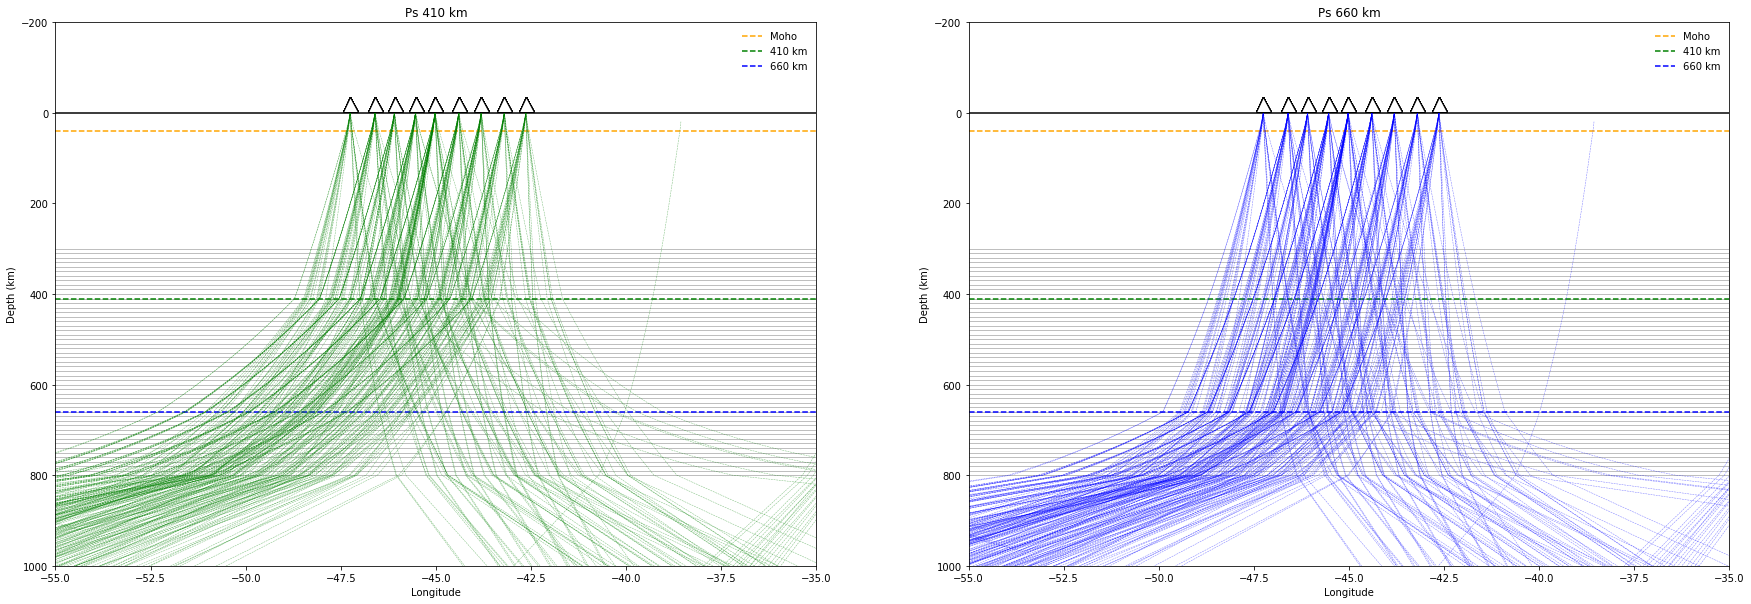

In [17]:
fig, (ax1,ax2)= plt.subplots(nrows=1, ncols=2,figsize=(30, 10))



    
for i,j in enumerate(PP_depth_P410s):
    ax1.plot(PP_lon_P410s[i],j,'g--',lw=0.5,alpha=0.5)
ax1.set_title('Ps 410 km')

for i,j in enumerate(PP_depth_P660s):
    ax2.plot(PP_lon_P660s[i],j,'b--',lw=0.5,alpha=0.5)
ax2.set_title('Ps 660 km')
    
for i,j in enumerate(camadas_terra_10_km):
    ax1.hlines(j,-55,-35,lw=0.5,alpha=0.5)
    ax2.hlines(j,-55,-35,lw=0.5,alpha=0.5)

for i,j in enumerate(event_depth):
    ax1.plot(sta_long[i],-20, color='w', marker='^', markersize=15,markeredgecolor='k')
    ax2.plot(sta_long[i],-20, color='w', marker='^', markersize=15,markeredgecolor='k')

    
ax1.hlines(0,-55,-35,colors='k',linestyles='solid')
ax1.hlines(40,-55,-35,colors='orange',linestyles='dashed',label='Moho')
ax1.hlines(410,-55,-35,colors='g',linestyles='dashed',label='410 km')
ax1.hlines(660,-55,-35,colors='b',linestyles='dashed',label='660 km')

ax1.set_ylim(1000,-200)
ax1.set_ylabel('Depth (km)')
ax1.set_xlabel('Longitude')

ax1.legend(loc=0,edgecolor='w',fancybox=True)
ax1.set_xlim(-55,-35)

ax2.hlines(0,-55,-35,colors='k',linestyles='solid')
ax2.hlines(40,-55,-35,colors='orange',linestyles='dashed',label='Moho')
ax2.hlines(410,-55,-35,colors='g',linestyles='dashed',label='410 km')
ax2.hlines(660,-55,-35,colors='b',linestyles='dashed',label='660 km')

ax2.set_ylim(1000,-200)
ax2.set_ylabel('Depth (km)')
ax2.set_xlabel('Longitude')

ax2.legend(loc=0,edgecolor='w',fancybox=True)
ax2.set_xlim(-55,-35)


#fig.savefig('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/ray_path.png',dpi=300)

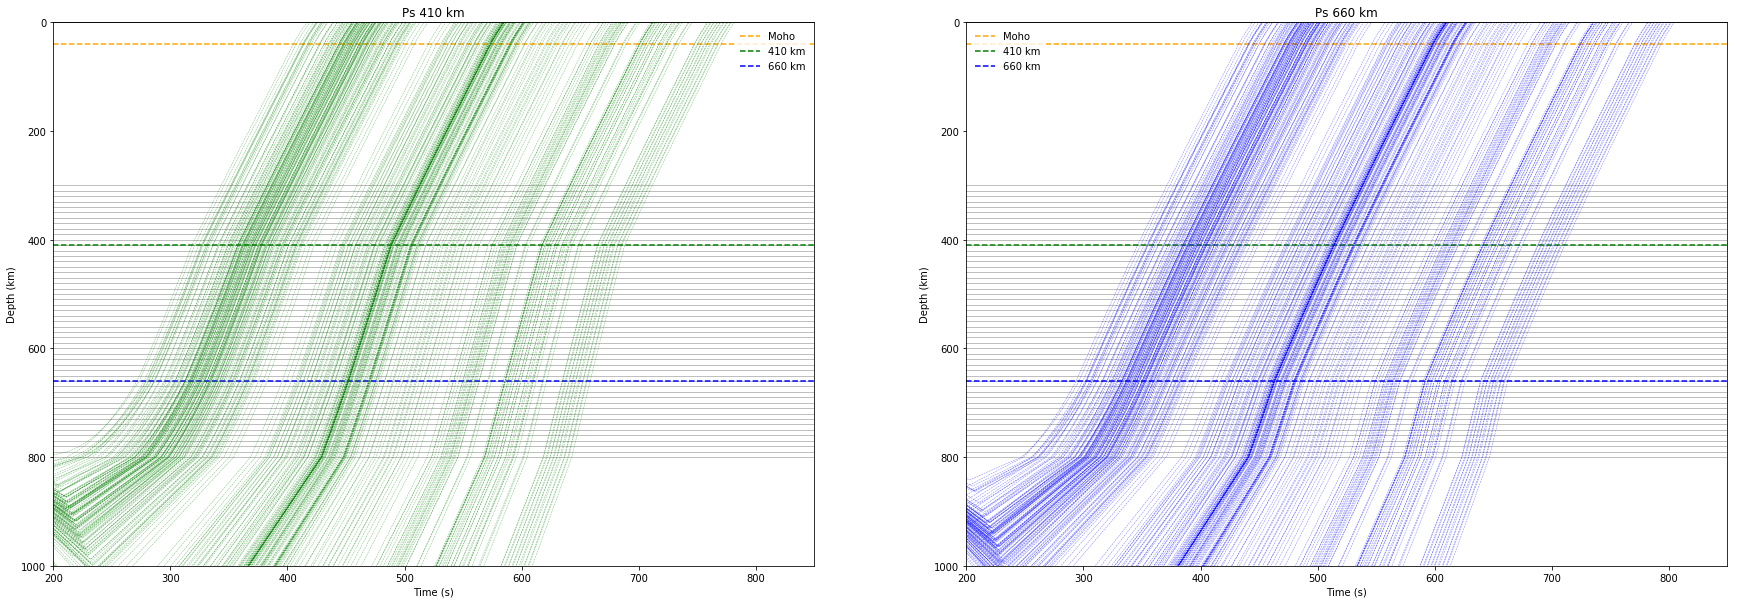

In [18]:
fig, (ax1,ax2)= plt.subplots(nrows=1, ncols=2,figsize=(30, 10))

   
for i,j in enumerate(PP_depth_P410s):
    ax1.plot(PP_time_P410s[i],j,'g--',lw=0.5,alpha=0.5)
ax1.set_title('Ps 410 km')

for i,j in enumerate(PP_depth_P660s):
    ax2.plot(PP_time_P660s[i],j,'b--',lw=0.5,alpha=0.5)
ax2.set_title('Ps 660 km')
    
for i,j in enumerate(camadas_terra_10_km):
    ax1.hlines(j,0,1000,lw=0.5,alpha=0.5)
    ax2.hlines(j,0,1000,lw=0.5,alpha=0.5)

ax1.hlines(0,200,850,colors='k',linestyles='solid')
ax1.hlines(40,200,850,colors='orange',linestyles='dashed',label='Moho')
ax1.hlines(410,200,850,colors='g',linestyles='dashed',label='410 km')
ax1.hlines(660,200,850,colors='b',linestyles='dashed',label='660 km')

ax1.set_xlim(200,850)
ax1.set_ylim(1000,0)
ax1.set_ylabel('Depth (km)')
ax1.set_xlabel('Time (s)')

ax1.legend(loc=0,edgecolor='w',fancybox=True)

ax2.hlines(0,200,850,colors='k',linestyles='solid')
ax2.hlines(40,200,850,colors='orange',linestyles='dashed',label='Moho')
ax2.hlines(410,200,850,colors='g',linestyles='dashed',label='410 km')
ax2.hlines(660,200,850,colors='b',linestyles='dashed',label='660 km')

ax2.set_xlim(200,850)
ax2.set_ylim(1000,0)
ax2.set_ylabel('Depth (km)')
ax2.set_xlabel('Time (s)')

ax2.legend(loc=0,edgecolor='w',fancybox=True)


#fig.savefig('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/ray_path.png',dpi=300)

# Piercing Points -410 km

In [19]:
pp_410_lat  = [[]]*len(PP_lon_P410s)
pp_410_long  = [[]]*len(PP_lon_P410s)


for i,j in enumerate(PP_lon_P410s):
    for k,l in enumerate(j):
        if -55 <= l <= -35 and PP_depth_P410s[i][k] == 410:
                pp_410_lat[i] = PP_lat_P410s[i][k] 
                pp_410_long[i] = l

# Piercing Points -660 km

In [20]:
pp_660_lat  = [[]]*len(PP_lon_P660s)
pp_660_long  = [[]]*len(PP_lon_P660s)


for i,j in enumerate(PP_lon_P660s):
    for k,l in enumerate(j):
        if -55 <= l <= -35 and PP_depth_P660s[i][k] == 660:
                pp_660_lat[i] = PP_lat_P660s[i][k] 
                pp_660_long[i] = l

# Criando o GRID

In [21]:
area_lat = [-15, 0]
area_lon = [-55, -35]

In [22]:
area = (area_lon[0], area_lon[1], area_lat[0], area_lat[1])

shape = (abs(abs(area_lon[1]) - abs(area_lon[0]))*3, abs(abs(area_lat[1]) - abs(area_lat[0]))*3)

# First, we need to know the real data at the grid points
grdx, grdy = gridder.regular(area, shape)

Text(0.5,1.08,'BIN DATA')

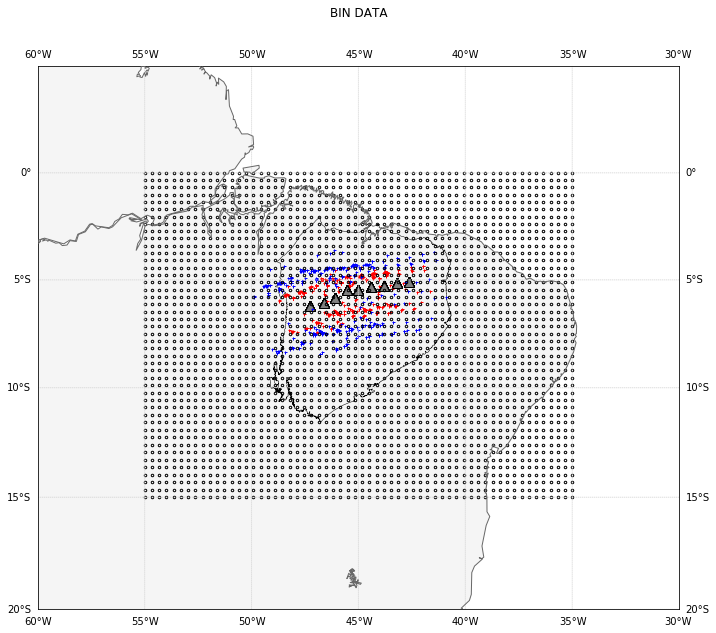

In [23]:
fig=plt.figure(figsize=(20,10))



project_Lat = -5
project_Lon = -45

m = Basemap(resolution='l',projection='merc',lat_0=project_Lat, lon_0=project_Lon,llcrnrlon=-60.,
            llcrnrlat=-20.,urcrnrlon=-30.,urcrnrlat=5.)

m.readshapefile('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba',name='bacia')

for lon, lat in zip(sta_long,sta_lat):
    x,y = m(lon, lat)
    msize = 10
    m.plot(x, y, '^',markersize=msize,markeredgecolor='k',markerfacecolor='grey')

    
for lon, lat in zip(pp_410_long,pp_410_lat):
    x,y = m(lon, lat)
    msize = 3
    m.plot(x, y, '+',markersize=msize,markeredgecolor='r',markerfacecolor='k')
    
for lon, lat in zip(pp_660_long,pp_660_lat):
    x,y = m(lon, lat)
    msize = 3
    m.plot(x, y, '+',markersize=msize,markeredgecolor='b',markerfacecolor='k')
    
for lon, lat in zip(grdx,grdy):
    x,y = m(lon, lat)
    msize = 5
    m.plot(x, y, '.',markersize=msize,markeredgecolor='k',markerfacecolor="None")

m.fillcontinents(color='whitesmoke',lake_color=None)
m.drawcoastlines(color='dimgray',zorder=10)
m.drawmeridians(np.arange(0, 360, 5),color='lightgrey',labels=[True,True,True,True])
m.drawparallels(np.arange(-90, 90, 5),color='lightgrey',labels=[True,True,True,True])


plt.title('BIN DATA', y=1.08)

# Filtrando os pontos do GRID

In [24]:
dist_pp_grid_min = [[]]*len(grdx)
for i,j in enumerate(grdx):
    dist_pp_grid_min[i] = [np.sqrt((j - pp_410_long[k])**2 + (grdy[i] - l)**2) for k,l in enumerate(pp_410_lat)]
    
dist_pp_grid_max = [[]]*len(grdx)
for i,j in enumerate(grdx):
    dist_pp_grid_max[i] = [np.sqrt((j - pp_660_long[k])**2 + (grdy[i] - l)**2) for k,l in enumerate(pp_660_lat)]

In [25]:
dist_grid_piercing_points = 1
number_piercing_points_per_bin = 10 

grid_sel_min = []
grid_sel_min_data = []
for i,j in enumerate(dist_pp_grid_min):
    vect_j = np.array(j) 
    indices = vect_j.argsort()
    if vect_j[indices[number_piercing_points_per_bin]] < dist_grid_piercing_points:
        grid_sel_min.append((grdx[i],grdy[i]))
        
grid_sel_max = []
grid_sel_min_data = []

for i,j in enumerate(dist_pp_grid_max):
    vect_j = np.array(j) 
    indices = vect_j.argsort()
    if vect_j[indices[number_piercing_points_per_bin]] < dist_grid_piercing_points:
        grid_sel_max.append((grdx[i],grdy[i]))


In [26]:
grid_sel = grid_sel_min+grid_sel_max

In [27]:
grid_selected = set(map(tuple,grid_sel))

In [28]:
grid_sel_x = []
grid_sel_y = []
for i,j in enumerate(grid_selected):
    grid_sel_x.append(j[0])
    grid_sel_y.append(j[1])

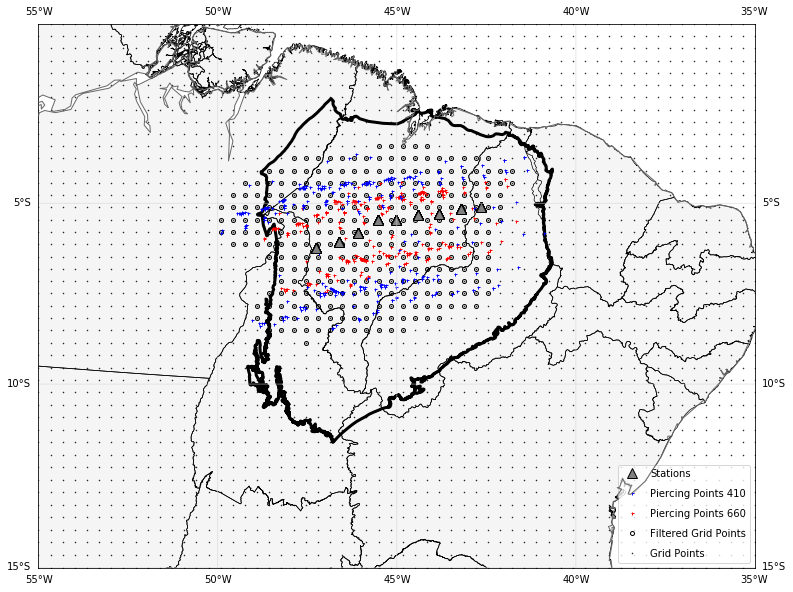

In [29]:
fig=plt.figure(figsize=(20,10))



project_Lat = -5
project_Lon = -45

m = Basemap(resolution='l',projection='merc',lat_0=project_Lat, lon_0=project_Lon,llcrnrlon=-55.,
            llcrnrlat=-15.,urcrnrlon=-35.,urcrnrlat=0)

m.readshapefile('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba',name='bacia',linewidth=3)
m.readshapefile('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/Estados/Brasil',name='estados',linewidth=0.7)

for lon, lat in zip(grdx,grdy):
    x,y = m(lon, lat)
    msize = 0.5
    l5, = m.plot(x, y, 'o',markersize=msize,markeredgecolor='k',markerfacecolor="None")

for lon, lat in zip(grid_sel_x, grid_sel_y):
    x,y = m(lon, lat)
    msize = 4
    l4, = m.plot(x, y, 'o',markersize=msize,markeredgecolor='k',markerfacecolor="None")
    
for lon, lat in zip(pp_410_long,pp_410_lat):
    x,y = m(lon, lat)
    msize = 3
    l3, = m.plot(x, y, '+',markersize=msize,markeredgecolor='r',markerfacecolor='k')
    
for lon, lat in zip(pp_660_long,pp_660_lat):
    x,y = m(lon, lat)
    msize = 3
    l2, = m.plot(x, y, '+',markersize=msize,markeredgecolor='b',markerfacecolor='k')
    

for lon, lat in zip(sta_long,sta_lat):
    x,y = m(lon, lat)
    msize = 10
    l1, = m.plot(x, y, '^',markersize=msize,markeredgecolor='k',markerfacecolor='grey')

m.fillcontinents(color='whitesmoke',lake_color=None)
m.drawcoastlines(color='dimgray',zorder=10)
m.drawmeridians(np.arange(0, 360, 5),color='lightgrey',labels=[True,True,True,True])
m.drawparallels(np.arange(-90, 90, 5),color='lightgrey',labels=[True,True,True,True])

        
label=['Stations','Piercing Points 410','Piercing Points 660','Filtered Grid Points','Grid Points']
plt.legend([l1,l2,l3,l4,l5],label,scatterpoints=1, frameon=True,labelspacing=1, loc='lower right',facecolor='w')

#plt.title('BIN DATA', y=1.08)

# Importando as profundidades e os tempos para a conversão Ps para os eventos das estações BP

In [30]:
P_depth_str = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/velocity_model/Phases/depth/Ps_depth.txt',delimiter='[]',dtype='str')
P_depth = [[]]*len(P_depth_str)
for i,j in enumerate(P_depth_str):
    a = j.split('[')
    b = a[1].split(']')
    c = b[0]
    P_depth[i] = [float(l) for l in c.split(',')]

In [31]:
P_time_str = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/velocity_model/Phases/time/Ps_time.txt',delimiter='[]',dtype='str')
P_time = [[]]*len(P_time_str)
for i,j in enumerate(P_time_str):
    a = j.split('[')
    b = a[1].split(']')
    c = b[0]
    P_time[i] = [float(l) for l in c.split(',')]

In [32]:
P_dist_str = np.genfromtxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/transition_zone/velocity_model/Phases/dist_event/Ps_dist_event.txt',delimiter='[]',dtype='str')
P_dist = [[]]*len(P_dist_str)
for i,j in enumerate(P_dist_str):
    a = j.split('[')
    b = a[1].split(']')
    c = b[0]
    P_dist[i] = [float(l) for l in c.split(',')]

(100, 0)

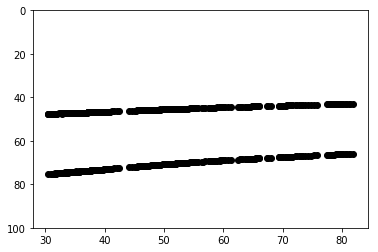

In [33]:
for i,j in enumerate(P_depth):
    [plt.plot(P_dist[i][k],P_time[i][k],'ko') for k,l in enumerate(j) if l == 410]
    [plt.plot(P_dist[i][k],P_time[i][k],'ko') for k,l in enumerate(j) if l == 660] 

plt.ylim(100,0)

# Migrando os dados de tempo para profundidade

In [34]:
RF_amplitude_time = [[]]*len(P_depth)
for i,j in enumerate(P_depth):
    sta_t = j
    RF_t = camadas_terra_10_km
    RF_amplitude_time[i] = [P_time[i][sta_t.index(l)] for k,l in enumerate(RF_t)]

In [35]:
RF_amplitude = []
for i,j in enumerate(RF_amplitude_time):
    sta_t = [round(l,1) for k,l in enumerate(sta_time[i])]
    RF_t = [round(l,1) for k,l in enumerate(j)]
    RF_amplitude.append([sta_data[i][sta_t.index(l)] for k,l in enumerate(RF_t)])

In [36]:
RF_amplitude_time = [[]]*len(P_depth)
for i,j in enumerate(P_depth):
    sta_t = j
    RF_t = camadas_terra_10_km
    RF_amplitude_time[i] = [P_time[i][sta_t.index(l)] if l in sta_t else -1 for k,l in enumerate(RF_t)]

In [37]:
RF_amplitude = [[]]*len(RF_amplitude_time)
for i,j in enumerate(RF_amplitude_time):
    sta_t = [round(l,1) for k,l in enumerate(sta_time[i])]
    RF_t = [round(l,1) for k,l in enumerate(j)]
    RF_amplitude[i] = [sta_data[i][sta_t.index(l)] if l != -1 else 0 for k,l in enumerate(RF_t)]

In [38]:
print(len(pp_410_lat))

322


# Empilhando os dados nos pontos do GRID filtrado

In [39]:
dist_between_grid_piercing_points = 0.5
dados_grid_lat = pp_410_lat
dados_grid_lon = pp_410_long


RF_data_raw = [[]]*len(grid_sel_x)
RF_RAY_raw = [[]]*len(grid_sel_x)

for i,j in enumerate(grid_sel_x):
    RF_data_raw[i] = [np.array(RF_amplitude[k])  for k,l in enumerate(dados_grid_lat) if np.sqrt((j - dados_grid_lon[k])**2 + (grid_sel_y[i] - l)**2) < dist_between_grid_piercing_points]
    RF_RAY_raw[i] = [event_ray[k]  for k,l in enumerate(dados_grid_lat) if np.sqrt((j - dados_grid_lon[k])**2 + (grid_sel_y[i] - l)**2) < dist_between_grid_piercing_points]

In [40]:
RF_stacking = []
len_RF_stacking = []
RF_ray_stacking = []

for i,j in enumerate(RF_data_raw):
    if len(j) > 10:
        RF_stacking.append(sum(j)/len(j))
        len_RF_stacking.append(len(j))
        RF_ray_stacking.append(sum(RF_RAY_raw[i])/len(j))
    else:
        RF_stacking.append([])
        len_RF_stacking.append(0)
        RF_ray_stacking.append(0)

Text(0.5,1.08,'BIN DATA')

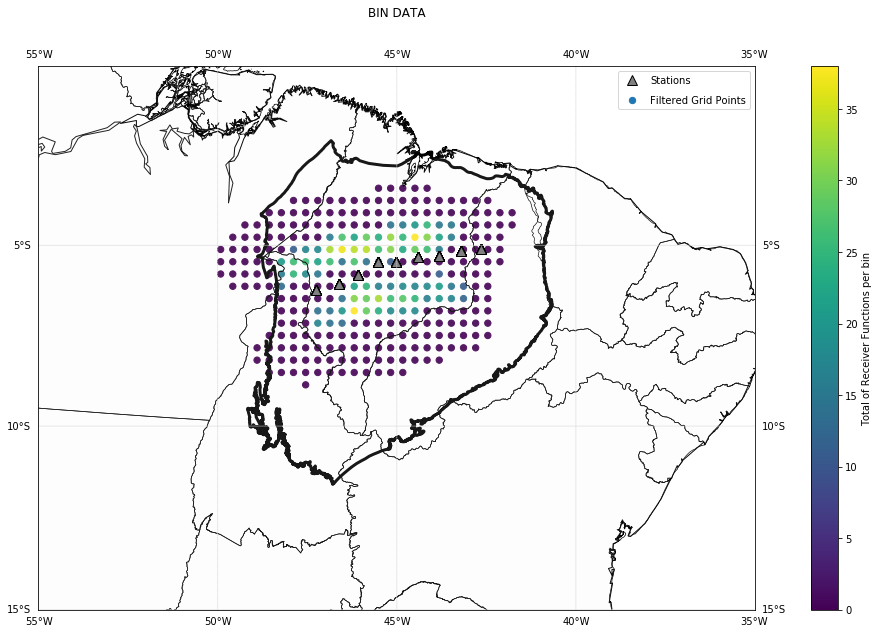

In [41]:
fig=plt.figure(figsize=(20,10))

project_Lat = -5
project_Lon = -45

m = Basemap(resolution='l',projection='merc',lat_0=project_Lat, lon_0=project_Lon,llcrnrlon=-55.,
            llcrnrlat=-15.,urcrnrlon=-35.,urcrnrlat=0)


m.readshapefile('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba',name='bacia',linewidth=3)
m.readshapefile('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/Estados/Brasil',name='estados',linewidth=0.7)


lats = grid_sel_y
lons = grid_sel_x
RF_number = len_RF_stacking
x, y = m(lons,lats)
sc = m.scatter(x,y,40,RF_number,cmap='viridis',marker='o')
plt.colorbar(sc,label='Total of Receiver Functions per bin')


for lon, lat in zip(sta_long,sta_lat):
    x,y = m(lon, lat)
    msize = 10
    l1, = m.plot(x, y, '^',markersize=msize,markeredgecolor='k',markerfacecolor='grey')

m.fillcontinents(color='whitesmoke',lake_color=None,zorder=2,alpha=0.1)
m.drawcoastlines(color='k',zorder=1)
m.drawmeridians(np.arange(0, 360, 5),color='lightgrey',labels=[True,True,True,True])
m.drawparallels(np.arange(-90, 90, 5),color='lightgrey',labels=[True,True,True,True])

plt.legend([l1,sc],['Stations','Filtered Grid Points'],scatterpoints=1, frameon=True,labelspacing=1, loc='upper right',facecolor='w')
plt.title('BIN DATA', y=1.08)

# Criando perfis para o GRID

## Perfil A-B

In [42]:
AB_lon_line = [-50,-41]
AB_lat_line = [-6,-4]

#AB_lon_line = [-50,-41]
#AB_lat_line = [-7.5,-5.5]

In [43]:
AB_lon = np.linspace(AB_lon_line[0],AB_lon_line[1],abs(abs(AB_lon_line[1])-abs(AB_lon_line[0]))*4)
AB_lat = np.linspace(AB_lat_line[0],AB_lat_line[1],abs(abs(AB_lon_line[1])-abs(AB_lon_line[0]))*4)

Text(0.5,1.08,'BIN DATA and Profile')

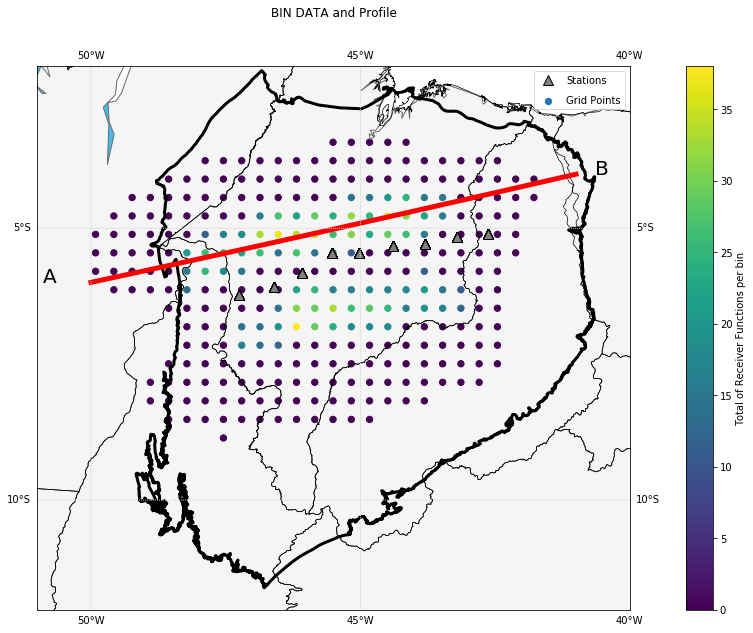

In [44]:
fig=plt.figure(figsize=(20,10))

project_Lat = -5
project_Lon = -45

m = Basemap(resolution='l',projection='merc',lat_0=project_Lat, lon_0=project_Lon,llcrnrlon=-51.,
            llcrnrlat=-12.,urcrnrlon=-40.,urcrnrlat=-2)

m.readshapefile('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba',name='bacia',linewidth=3)
m.readshapefile('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/Estados/Brasil',name='estados',linewidth=0.7)


xA, yA = m(AB_lon_line[0],AB_lat_line[0])
plt.text(xA-100000, yA, 'A',fontsize=20)

xB, yB = m(AB_lon_line[1],AB_lat_line[1])
plt.text(xB+40000, yB, 'B',fontsize=20)

m.drawgreatcircle(AB_lon_line[0],AB_lat_line[0],AB_lon_line[1],AB_lat_line[1],linewidth=5,color='r')

for lon, lat in zip(AB_lon,AB_lat):
    x,y = m(lon, lat)
    msize = 10
    #l1, = m.plot(x, y, 'o',markersize=msize,markeredgecolor='k',markerfacecolor='y')

lats = grid_sel_y
lons = grid_sel_x
RF_number = len_RF_stacking
x, y = m(lons,lats)
sc = m.scatter(x,y,40,RF_number,cmap='viridis',marker='o')
plt.colorbar(sc,label='Total of Receiver Functions per bin')

for lon, lat in zip(sta_long,sta_lat):
    x,y = m(lon, lat)
    msize = 10
    l1, = m.plot(x, y, '^',markersize=msize,markeredgecolor='k',markerfacecolor='grey')

m.fillcontinents(color='whitesmoke',lake_color='#46bcec',zorder=0)
m.drawcoastlines(color='dimgray',zorder=1)
m.drawmeridians(np.arange(0, 360, 5),color='lightgrey',labels=[True,True,True,True])
m.drawparallels(np.arange(-90, 90, 5),color='lightgrey',labels=[True,True,True,True])

plt.legend([l1,sc],['Stations','Grid Points'],scatterpoints=1, frameon=True,labelspacing=1, loc='upper right',facecolor='w')
plt.title('BIN DATA and Profile', y=1.08)

In [45]:
RF_data_profile = []
RF_RAY_profile = []

for i,j in enumerate(AB_lon):
    dist = [np.sqrt((j - grid_sel_x[k])**2 + (AB_lat[i] - l)**2)  for k,l in enumerate(grid_sel_y)]
    RF_data_profile.append(RF_stacking[dist.index(min(dist))])
    RF_RAY_profile.append(RF_ray_stacking[dist.index(min(dist))])

In [46]:
RF_data_profile_stacking = []
RF_RAY_profile_stacking = []
for i,j in enumerate(RF_data_profile):
    if len(j) > 10:
        RF_data_profile_stacking.append(j)
        RF_RAY_profile_stacking.append(RF_RAY_profile[i])

    #else:
        #RF_data_profile_stacking.append(np.zeros_like(camadas_terra_10_km))
        #RF_RAY_profile_stacking.append(0)

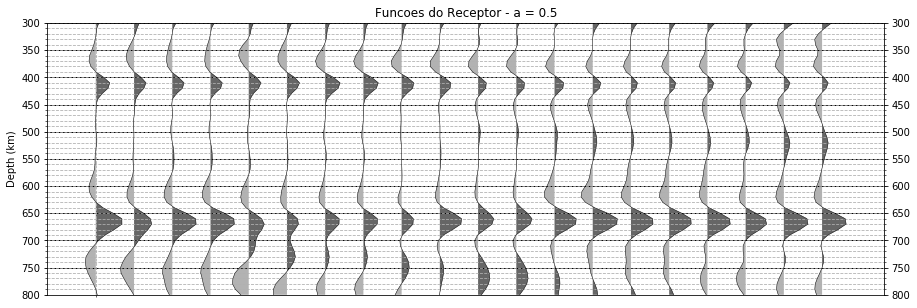

In [47]:
factor = 80

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
#fig, ax = plt.subplots(1, 1)

majorLocatorX = MultipleLocator(10)
majorLocatorY = MultipleLocator(50)
minorLocatorY = MultipleLocator(10)
minorLocatorX = MultipleLocator(5)


for i, j in enumerate(RF_data_profile_stacking): 
    #plt.plot(time_real-10,i/factor+j,'k',linewidth=0.5)
    #ax.text(i/factor,-25,"{0:.2f}".format(RF_RAY_profile_stacking[i]),rotation=45)
    ax.plot(i/factor+j,camadas_terra_10_km,'k',linewidth=0.5)
    ax.yaxis.set_major_locator(majorLocatorY)
    ax.xaxis.set_minor_locator(minorLocatorX)
    ax.yaxis.set_minor_locator(minorLocatorY)
    ax.grid(True,which='minor',linestyle='--')
    ax.grid(True,which='major',color='k',linewidth=1)

    ax.yaxis.set_ticks_position('both')

    ax.fill_betweenx(camadas_terra_10_km,i/factor+j,i/factor,where=(i/factor+j)>=i/factor, facecolor='black',alpha=0.6, interpolate=True)
    ax.fill_betweenx(camadas_terra_10_km,i/factor+j,i/factor,where=(i/factor+j)<=i/factor, facecolor='gray',alpha=0.6, interpolate=True)
    ax.set_title('Funcoes do Receptor - a = 0.5')
    ax.set_xticks([])
    ax.set_ylabel('Depth (km)')
    
    ax.tick_params(labelright=True)
    ax.set_ylim(800,300)

# Figura completa

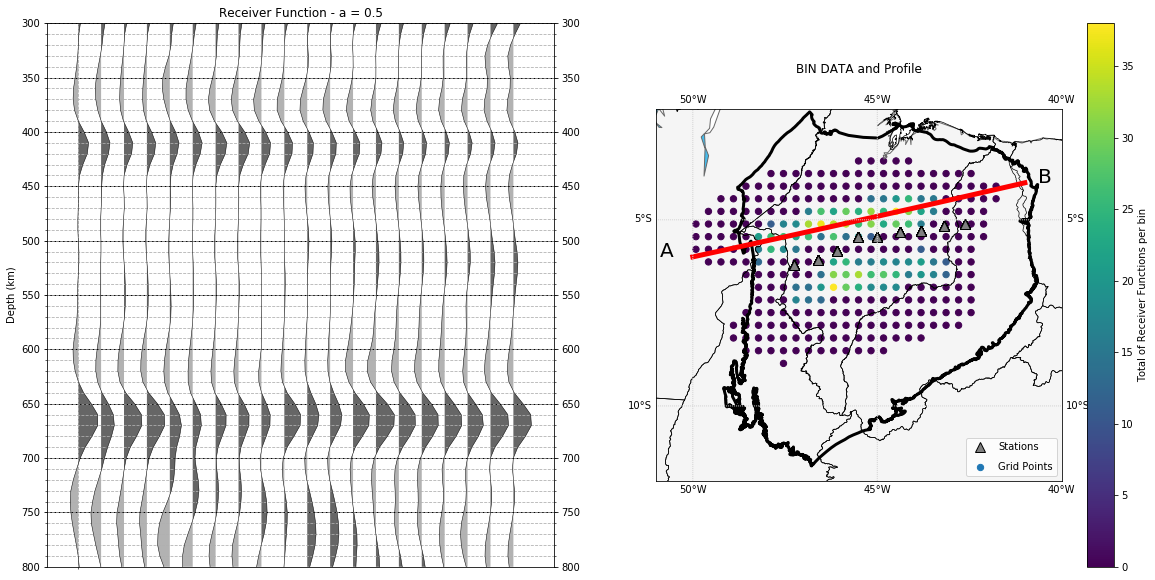

In [50]:
fig, (ax1,ax) = plt.subplots(1,2, figsize=(20, 10))

project_Lat = -5
project_Lon = -45

m = Basemap(resolution='l',projection='merc',lat_0=project_Lat, lon_0=project_Lon,llcrnrlon=-51.,
            llcrnrlat=-12.,urcrnrlon=-40.,urcrnrlat=-2,ax=ax)

m.readshapefile('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/bacia_parnaiba/bacia_parnaiba',name='bacia',linewidth=3)
m.readshapefile('/home/diogo/dados_doutorado/parnaiba_basin/SIG_dados/shapes/Estados/Brasil',name='estados',linewidth=0.7)


xA, yA = m(AB_lon_line[0],AB_lat_line[0])
plt.text(xA-100000, yA, 'A',fontsize=20)

xB, yB = m(AB_lon_line[1],AB_lat_line[1])
plt.text(xB+40000, yB, 'B',fontsize=20)

m.drawgreatcircle(AB_lon_line[0],AB_lat_line[0],AB_lon_line[1],AB_lat_line[1],linewidth=5,color='r')

for lon, lat in zip(AB_lon,AB_lat):
    x,y = m(lon, lat)
    msize = 10
    #l1, = m.plot(x, y, 'o',markersize=msize,markeredgecolor='k',markerfacecolor='y')

lats = grid_sel_y
lons = grid_sel_x
RF_number = len_RF_stacking
x, y = m(lons,lats)
sc = m.scatter(x,y,40,RF_number,cmap='viridis',marker='o')
plt.colorbar(sc,label='Total of Receiver Functions per bin')

for lon, lat in zip(sta_long,sta_lat):
    x,y = m(lon, lat)
    msize = 10
    l1, = m.plot(x, y, '^',markersize=msize,markeredgecolor='k',markerfacecolor='grey')

m.fillcontinents(color='whitesmoke',lake_color='#46bcec',zorder=0)
m.drawcoastlines(color='dimgray',zorder=1)
m.drawmeridians(np.arange(0, 360, 5),color='lightgrey',labels=[True,True,True,True])
m.drawparallels(np.arange(-90, 90, 5),color='lightgrey',labels=[True,True,True,True])

plt.legend([l1,sc],['Stations','Grid Points'],scatterpoints=1, frameon=True,labelspacing=1, loc='lower right',facecolor='w')
plt.title('BIN DATA and Profile', y=1.08)

factor = 100

majorLocatorX = MultipleLocator(10)
majorLocatorY = MultipleLocator(50)
minorLocatorY = MultipleLocator(10)
minorLocatorX = MultipleLocator(5)


for i, j in enumerate(RF_data_profile_stacking): 
    #plt.plot(time_real-10,i/factor+j,'k',linewidth=0.5)
    #ax.text(i/factor,-25,"{0:.2f}".format(RF_RAY_profile_stacking[i]),rotation=45)
    ax1.plot(i/factor+j,camadas_terra_10_km,'k',linewidth=0.5)
    ax1.yaxis.set_major_locator(majorLocatorY)
    ax1.xaxis.set_minor_locator(minorLocatorX)
    ax1.yaxis.set_minor_locator(minorLocatorY)
    ax1.grid(True,which='minor',linestyle='--')
    ax1.grid(True,which='major',color='k',linewidth=1)

    ax1.yaxis.set_ticks_position('both')

    ax1.fill_betweenx(camadas_terra_10_km,i/factor+j,i/factor,where=(i/factor+j)>=i/factor, facecolor='black',alpha=0.6, interpolate=True)
    ax1.fill_betweenx(camadas_terra_10_km,i/factor+j,i/factor,where=(i/factor+j)<=i/factor, facecolor='gray',alpha=0.6, interpolate=True)
    ax1.set_title('Receiver Function - a = 0.5')
    ax1.set_xticks([])
    ax1.set_ylabel('Depth (km)')
    
    ax1.tick_params(labelright=True)
    ax1.set_ylim(800,300)
